<a href="https://colab.research.google.com/github/riyamishra28/Early-Type-2-Diabetes-Prediction/blob/main/Ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving DiabetesPredict_Dataset.csv to DiabetesPredict_Dataset.csv


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         2029 non-null   float64
 1   No_Pation  2029 non-null   float64
 2   Gender     10000 non-null  object 
 3   AGE        10000 non-null  float64
 4   Urea       10000 non-null  float64
 5   Cr         10000 non-null  float64
 6   HbA1c      10000 non-null  float64
 7   Chol       10000 non-null  float64
 8   TG         10000 non-null  float64
 9   HDL        10000 non-null  float64
 10  LDL        10000 non-null  float64
 11  VLDL       10000 non-null  float64
 12  BMI        10000 non-null  float64
 13  CLASS      10000 non-null  object 
dtypes: float64(12), object(2)
memory usage: 1.1+ MB
None
Selected features: Index(['Gender', 'AGE', 'HbA1c', 'VLDL', 'BMI'], dtype='object')

🔹 Ensemble Model Performance Metrics:
✔️ Accuracy: 0.9758
✔️ Precision: 0.9759
✔️ Recall: 0.9758
✔️ F1 Score:

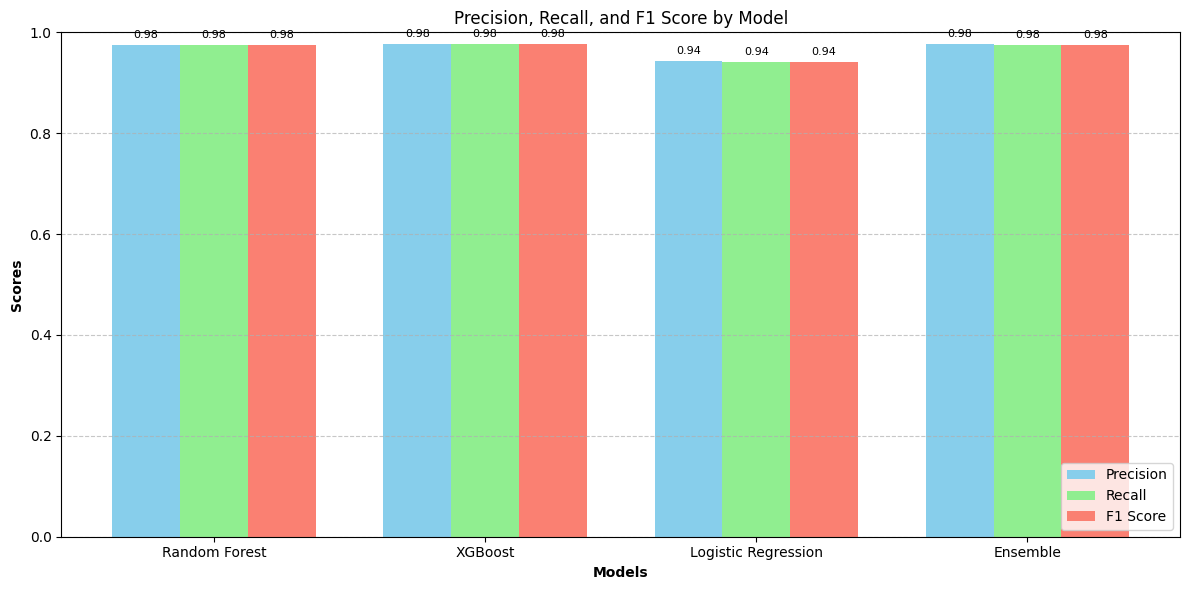

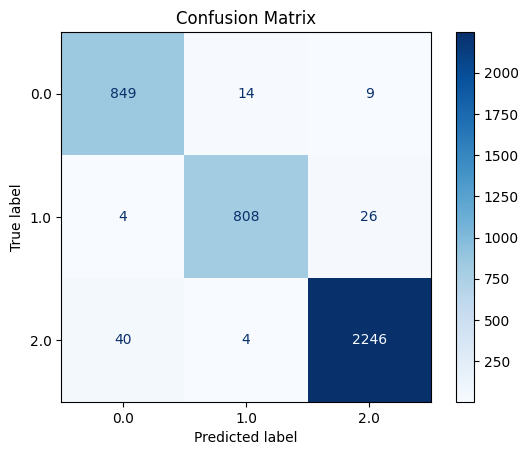

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif

# Load dataset
df = pd.read_csv("DiabetesPredict_Dataset.csv")

# Display basic dataset information
print(df.info())

# Handle categorical features if any
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Handle missing values using median imputation
imputer = SimpleImputer(strategy="median")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Splitting into features and target
X = df.drop(columns=["ID", "No_Pation", "CLASS"], errors='ignore')
y = df_imputed['CLASS']

# Feature selection - reduce to fewer features
selector = SelectKBest(f_classif, k=5)  # Select only 5 best features
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

# Create a new dataframe with only selected features
X_reduced = pd.DataFrame(X_selected, columns=selected_features)

# Splitting into training and testing sets with more test data (40%)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.4, random_state=42, stratify=y)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define simpler models with regularization
rf_model = RandomForestClassifier(
    n_estimators=50,         # Reduced from 100
    max_depth=3,             # Limit tree depth
    min_samples_split=10,    # Require more samples to split
    min_samples_leaf=5,      # Require more samples in leaves
    random_state=42
)

xgb_model = XGBClassifier(
    n_estimators=50,         # Reduced number of trees
    max_depth=3,             # Limit tree depth
    learning_rate=0.01,      # Smaller learning rate
    subsample=0.7,           # Use only 70% of samples for trees
    colsample_bytree=0.7,    # Use only 70% of features for trees
    reg_alpha=1,             # L1 regularization
    reg_lambda=1,            # L2 regularization
    eval_metric='logloss',
    random_state=42
)

lr_model = LogisticRegression(
    C=0.1,                   # Stronger regularization (inverse of regularization strength)
    max_iter=1000,
    random_state=42
)

# Train individual models
rf_model.fit(X_train_scaled, y_train)
xgb_model.fit(X_train_scaled, y_train)
lr_model.fit(X_train_scaled, y_train)

# Make predictions with each model and average them (simple ensemble)
rf_pred = rf_model.predict(X_test_scaled)
xgb_pred = xgb_model.predict(X_test_scaled)
lr_pred = lr_model.predict(X_test_scaled)

# Simple majority voting ensemble
y_pred = np.zeros(len(rf_pred))
for i in range(len(rf_pred)):
    votes = [rf_pred[i], xgb_pred[i], lr_pred[i]]
    y_pred[i] = max(set(votes), key=votes.count)

# For ROC-AUC calculation
y_pred_proba = (rf_model.predict_proba(X_test_scaled)[:, 1] +
                xgb_model.predict_proba(X_test_scaled)[:, 1] +
                lr_model.predict_proba(X_test_scaled)[:, 1]) / 3

# Calculate metrics for ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred)
ensemble_precision = precision_score(y_test, y_pred, average='weighted')
ensemble_recall = recall_score(y_test, y_pred, average='weighted')
ensemble_f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate metrics for individual models
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

xgb_precision = precision_score(y_test, xgb_pred, average='weighted')
xgb_recall = recall_score(y_test, xgb_pred, average='weighted')
xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')

lr_precision = precision_score(y_test, lr_pred, average='weighted')
lr_recall = recall_score(y_test, lr_pred, average='weighted')
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

# Check if ROC-AUC can be computed
if len(set(y)) == 2:  # Only for binary classification
    roc_auc = roc_auc_score(y_test, y_pred_proba)
else:
    roc_auc = "Not applicable for multiclass"

# Print ensemble results
print(f"\n🔹 Ensemble Model Performance Metrics:")
print(f"✔️ Accuracy: {ensemble_accuracy:.4f}")
print(f"✔️ Precision: {ensemble_precision:.4f}")
print(f"✔️ Recall: {ensemble_recall:.4f}")
print(f"✔️ F1 Score: {ensemble_f1:.4f}")
print(f"✔️ ROC-AUC Score: {roc_auc}")

# Print individual model performance
print("\n🔹 Individual Model Performance:")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_pred):.4f}")

# Plot bar chart for Precision, Recall, and F1 Score
plt.figure(figsize=(12, 6))

# Data for the bar chart
models = ['Random Forest', 'XGBoost', 'Logistic Regression', 'Ensemble']
metrics_data = {
    'Precision': [rf_precision, xgb_precision, lr_precision, ensemble_precision],
    'Recall': [rf_recall, xgb_recall, lr_recall, ensemble_recall],
    'F1 Score': [rf_f1, xgb_f1, lr_f1, ensemble_f1]
}

# Set width of bars
barWidth = 0.25
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create bars
plt.bar(r1, metrics_data['Precision'], width=barWidth, label='Precision', color='skyblue')
plt.bar(r2, metrics_data['Recall'], width=barWidth, label='Recall', color='lightgreen')
plt.bar(r3, metrics_data['F1 Score'], width=barWidth, label='F1 Score', color='salmon')

# Add labels and title
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Precision, Recall, and F1 Score by Model')
plt.xticks([r + barWidth for r in range(len(models))], models)
plt.ylim(0, 1.0)  # Set y-axis range from 0 to 1

# Add grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i, model in enumerate(models):
    for j, metric in enumerate(['Precision', 'Recall', 'F1 Score']):
        plt.text(i + j*barWidth, metrics_data[metric][i] + 0.01,
                 f'{metrics_data[metric][i]:.2f}',
                 ha='center', va='bottom', fontsize=8)

# Add legend
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Plot ROC Curve only for binary classification
if len(set(y)) == 2:
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()